In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py

import scanpy as sc

# If you use the code in Github's folder VITAE instead of installing 
# via PyPI, then you need to add parent folder path to load our package
import sys; sys.path.insert(0, '..')
from VITAE import load_data,VITAE

# Load data

Our algorithm requires at least two inputs:

- `count`$\in \mathbb{R}^{n_{\text{cell}}\ \ \times\ \ n_{\text{gene}}}$, the raw count matrix for the UMI/non-UMI model, or the preprocessed expression matrix for the Gaussian model.
- `NUM_CLUSTER`$\in \mathbb{N}^+$, the number of clusters.

One can also provides some prior information:

- `grouping`$\in \mathbb{R}^{n_{\text{cell}}}$, the true/estimated groupings
- `gene_names`$\in \mathbb{R}^{n_{\text{cell}}}$
- `cell_ids`$\in \mathbb{R}^{n_{\text{cell}}}$

We have prepare some datasets in **hdf5** format, which can be easily loaded by the following codes:

In [7]:
file_name = 'dentate'
dd = load_data(path='../data/',
                 file_name=file_name)

# To see the available fields of the dataset
print(dd)

AnnData object with n_obs × n_vars = 4007 × 14545
    obs: 'grouping'
    layers: 'count'


# Preprocess data

In [8]:
sc.pp.normalize_total(dd, target_sum=1e4)
sc.pp.log1p(dd)
sc.pp.highly_variable_genes(dd, min_mean=0.0125, max_mean=3, min_disp=0.5)


sc.pp.scale(dd, max_value=10)

sc.tl.pca(dd, svd_solver='arpack')
sc.pp.neighbors(dd, n_neighbors=10, n_pcs=40)
sc.tl.umap(dd)

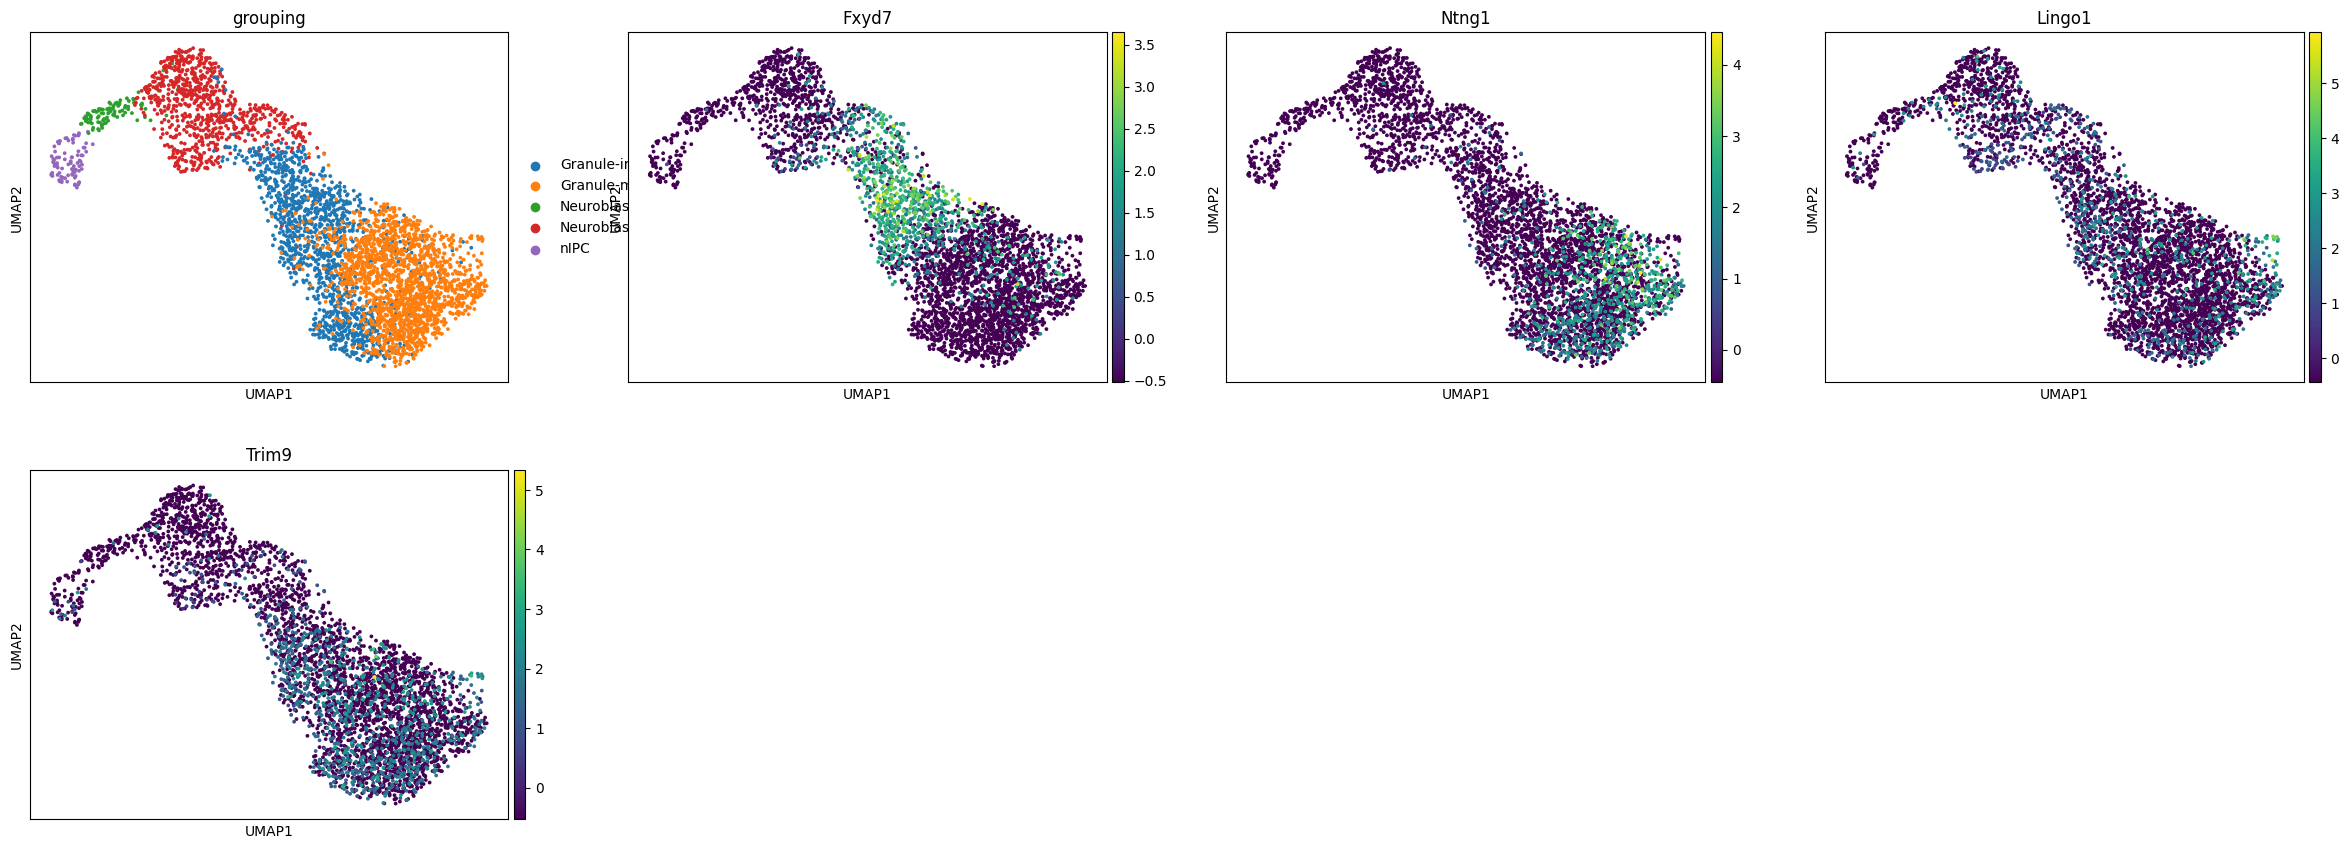

In [9]:
sc.pl.umap(dd, color=['grouping', 'Fxyd7', 'Ntng1', 'Lingo1', 'Trim9'])

# Build VITAE model

Now we are able to create the neural network.

In [10]:
model = VITAE(adata = dd, 
        hidden_layers = [32, 16],
        latent_space_dim = 8,
        model_type = 'Gaussian')

# Pretrain

In the current stage, we only define the Autoencoder. The latent sturcture is still undefined. Before adding that, we'd better pretrain the Autoencoder to learn a better reprsentation $Z$ of $X$.

A large batch size will give a better and stable model, while it takes more memory to run. So if you are concerned about this, you could reduce the batch size.

In [11]:
model.pre_train(learning_rate=1e-3,L = 1)

 86/200 [===========>..................] - ETA: 46sBest Epoch: 74. Best Metric: 66.095268.
Early stopping.
Pretrain Done.


# Clustering and initialize latent structure

If you have information of the grouping/labels of cells, you are free to use them to initialze the latent structure, so that you will get better estimate and inference results, especially when the sample size is small or the classes are unbalanced.

Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.
Calculate UMAP ...


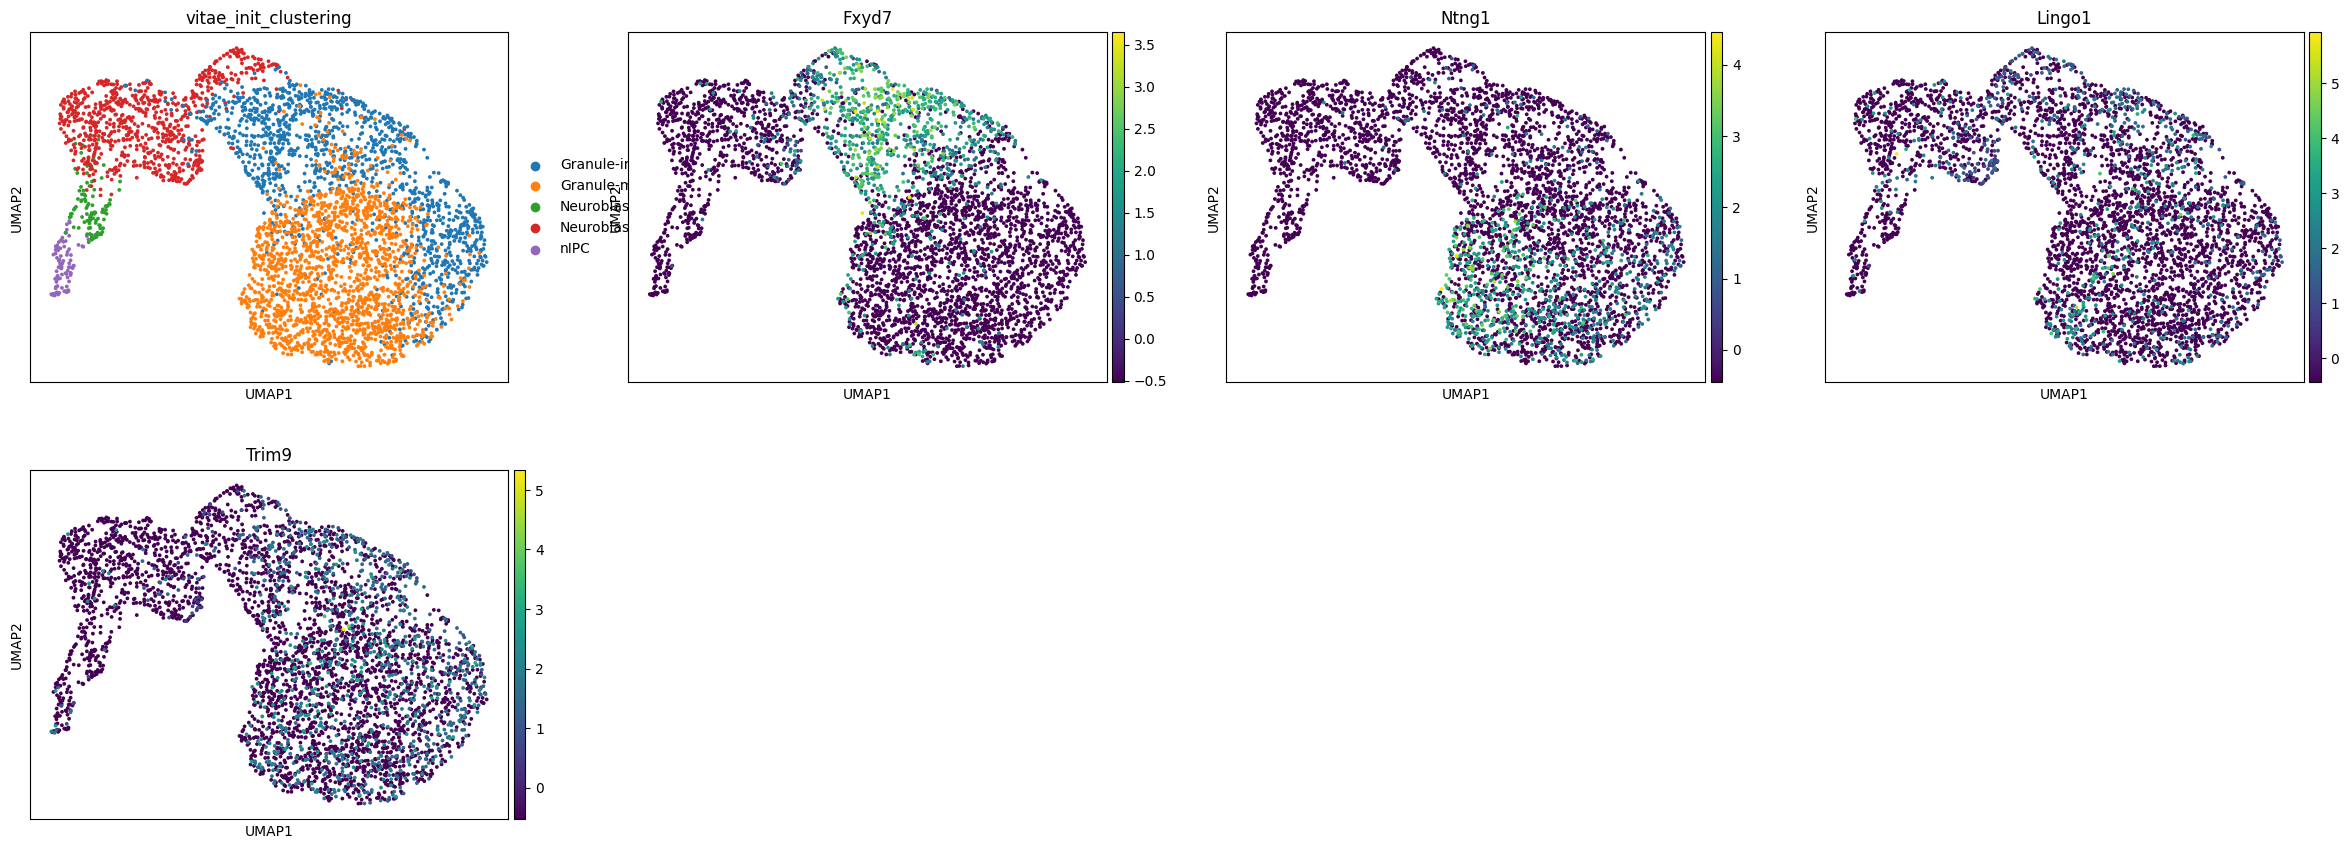

In [12]:
# You can give leiden cluster result to the initial cluster label
# model.init_latent_space(cluster_label = 'leiden')

model.init_latent_space(cluster_label= 'grouping', res = 0.4) 

model.visualize_latent(color=['vitae_init_clustering', 'Fxyd7', 'Ntng1', 'Lingo1', 'Trim9'])

In case we don't have labels, we could do Louvain clustering by the following codes. You can choose different resolution parameter to get satisfactory clustering results.

```
z = model.get_latent_z()
embed_z = umap.UMAP().fit_transform(z)
g = get_igraph(z)
labels = leidenalg_igraph(g, res = 0.6) 
plot_clusters(embed_z, labels)
print(np.unique(labels))
```

And we can also use estimated cluster labels from other algorithms and softwares.

# Train

In [13]:
model.train(early_stopping_tolerance = 0.01, beta = 1, early_stopping_relative = True)

Warmup:0
 24/200 [==>...........................] - ETA: 1:14Best Epoch: 13. Best Metric: 70.222122.
Early stopping.
Training Done!


# Inference

## Trajectory and Pseudotime

In [14]:
model.posterior_estimation(batch_size=32, L=100)

Computing posterior estimations over mini-batches.
126/126 [==============================] - 3s 20ms/step
New clustering labels saved as 'vitae_new_clustering' in self.adata.obs.


Calculate UMAP ...


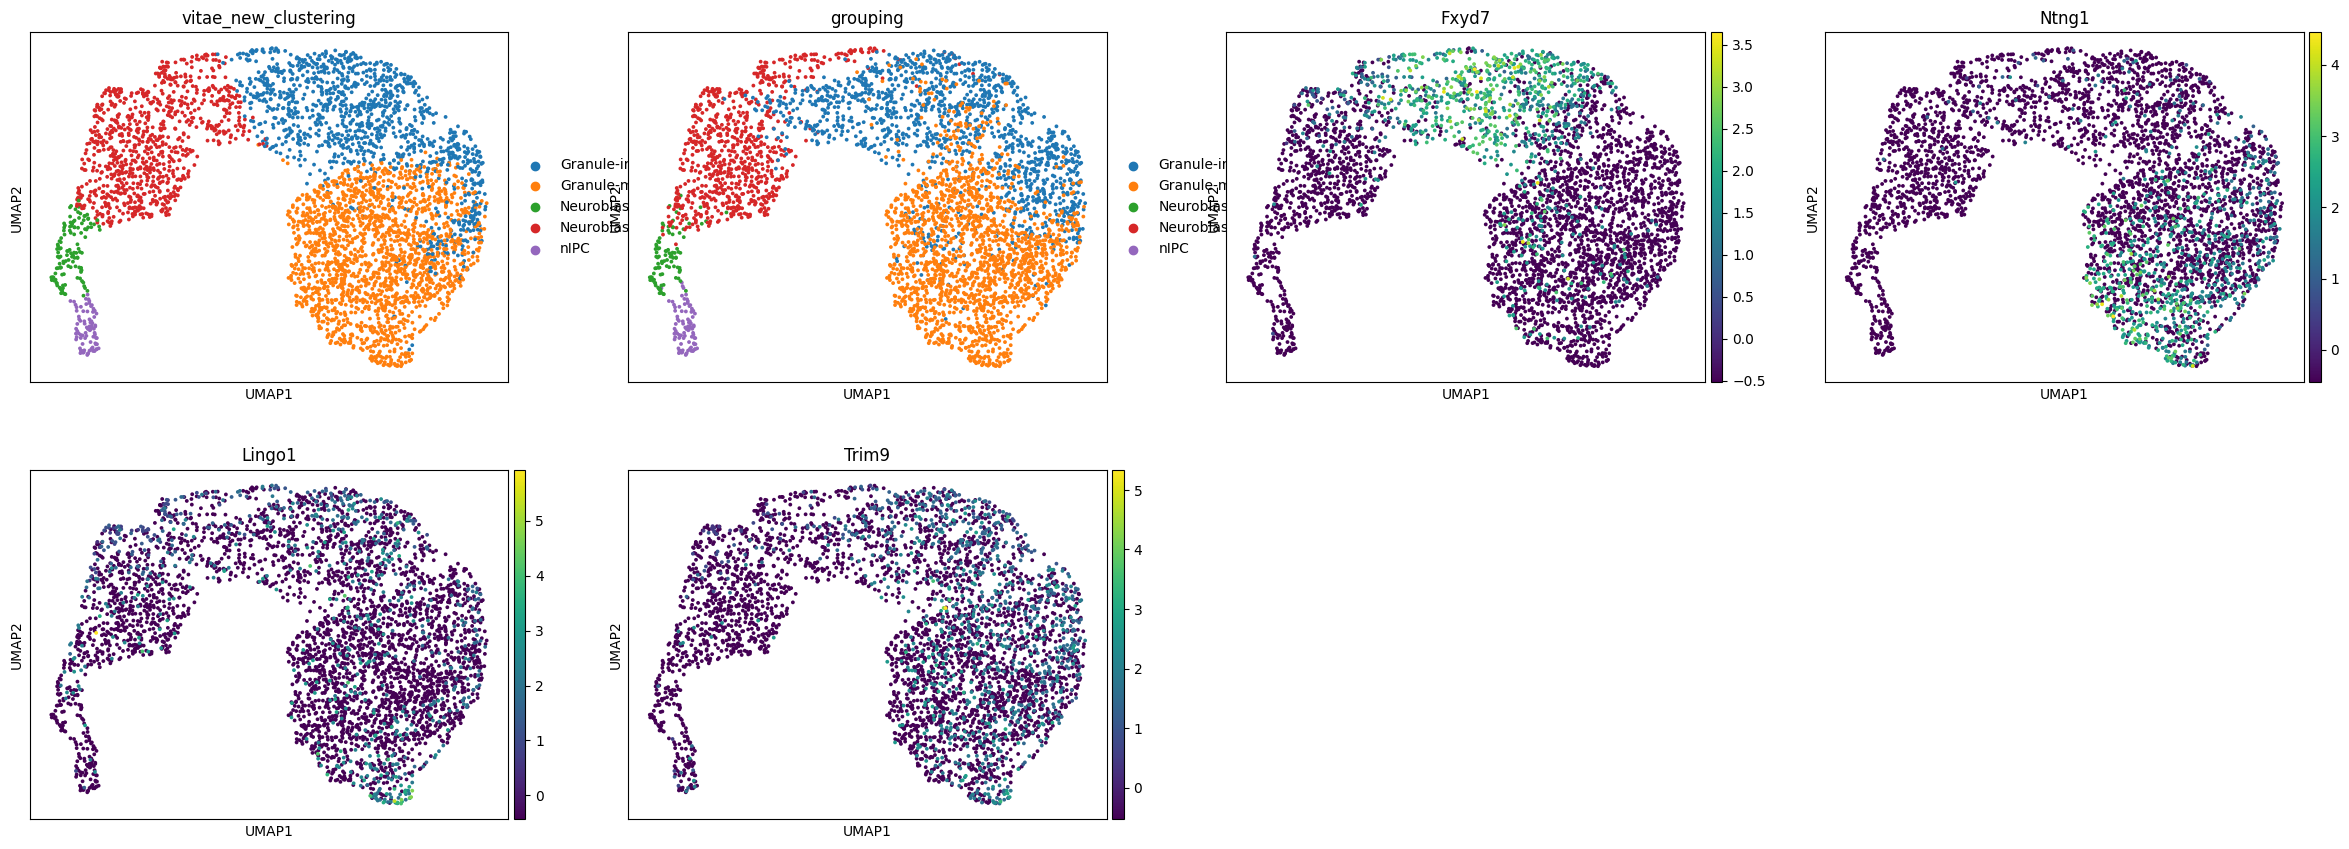

In [15]:
model.visualize_latent(color = ['vitae_new_clustering', 
                                'grouping', 'Fxyd7', 'Ntng1', 'Lingo1', 'Trim9'])

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


..\VITAE\VITAE.py:708: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


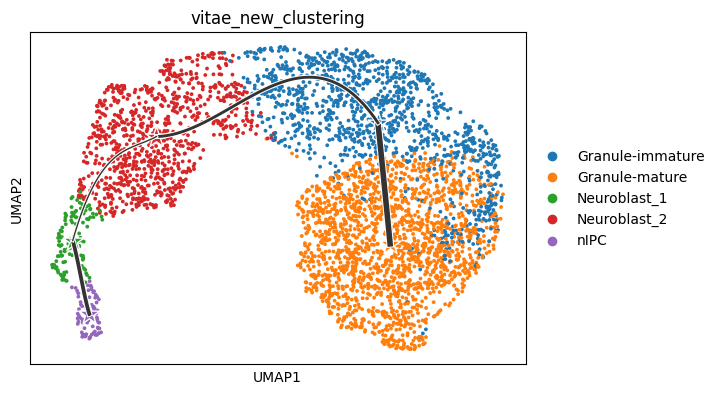

In [16]:
model.infer_backbone(cutoff = 0, no_loop = True, visualize = True)

Now, the user needs to provide the initial node for the trajectory.

Cell projection uncertainties stored as 'pseudotime' in self.adata.obs


..\VITAE\VITAE.py:996: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


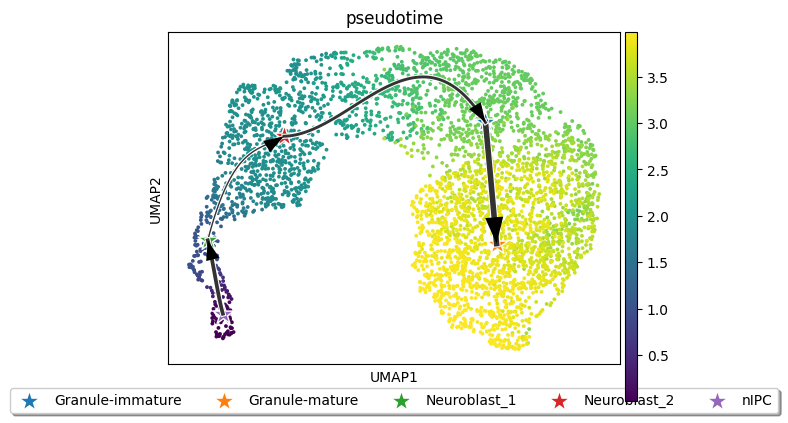

In [17]:
model.infer_trajectory(root = "nIPC")

We can now also estimate inference uncertainty.

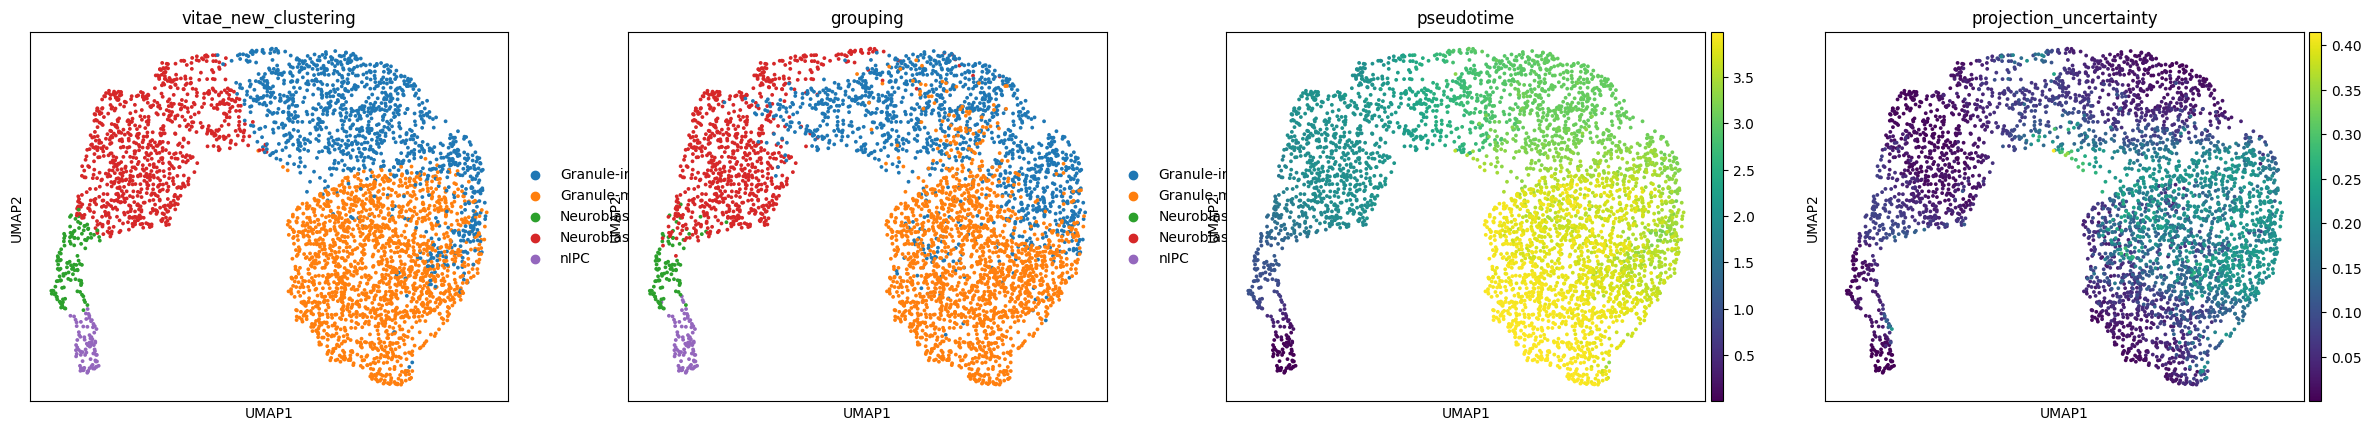

In [18]:
model.visualize_latent(color = ['vitae_new_clustering', 'grouping','pseudotime', 
                                'projection_uncertainty'], method = "UMAP")

# Extra analysis 

We also provide codes for differential analysis.

In [19]:
pseudotime = model.adata.obs.pseudotime.to_numpy()
cell_subset = [i for i, x in enumerate((pseudotime < 4) & (pseudotime > 2)) if x]
df = model.differential_expression_test(cell_subset = cell_subset)
maker_genes = df.sort_values("pvalue_adjusted_1").index[:5]

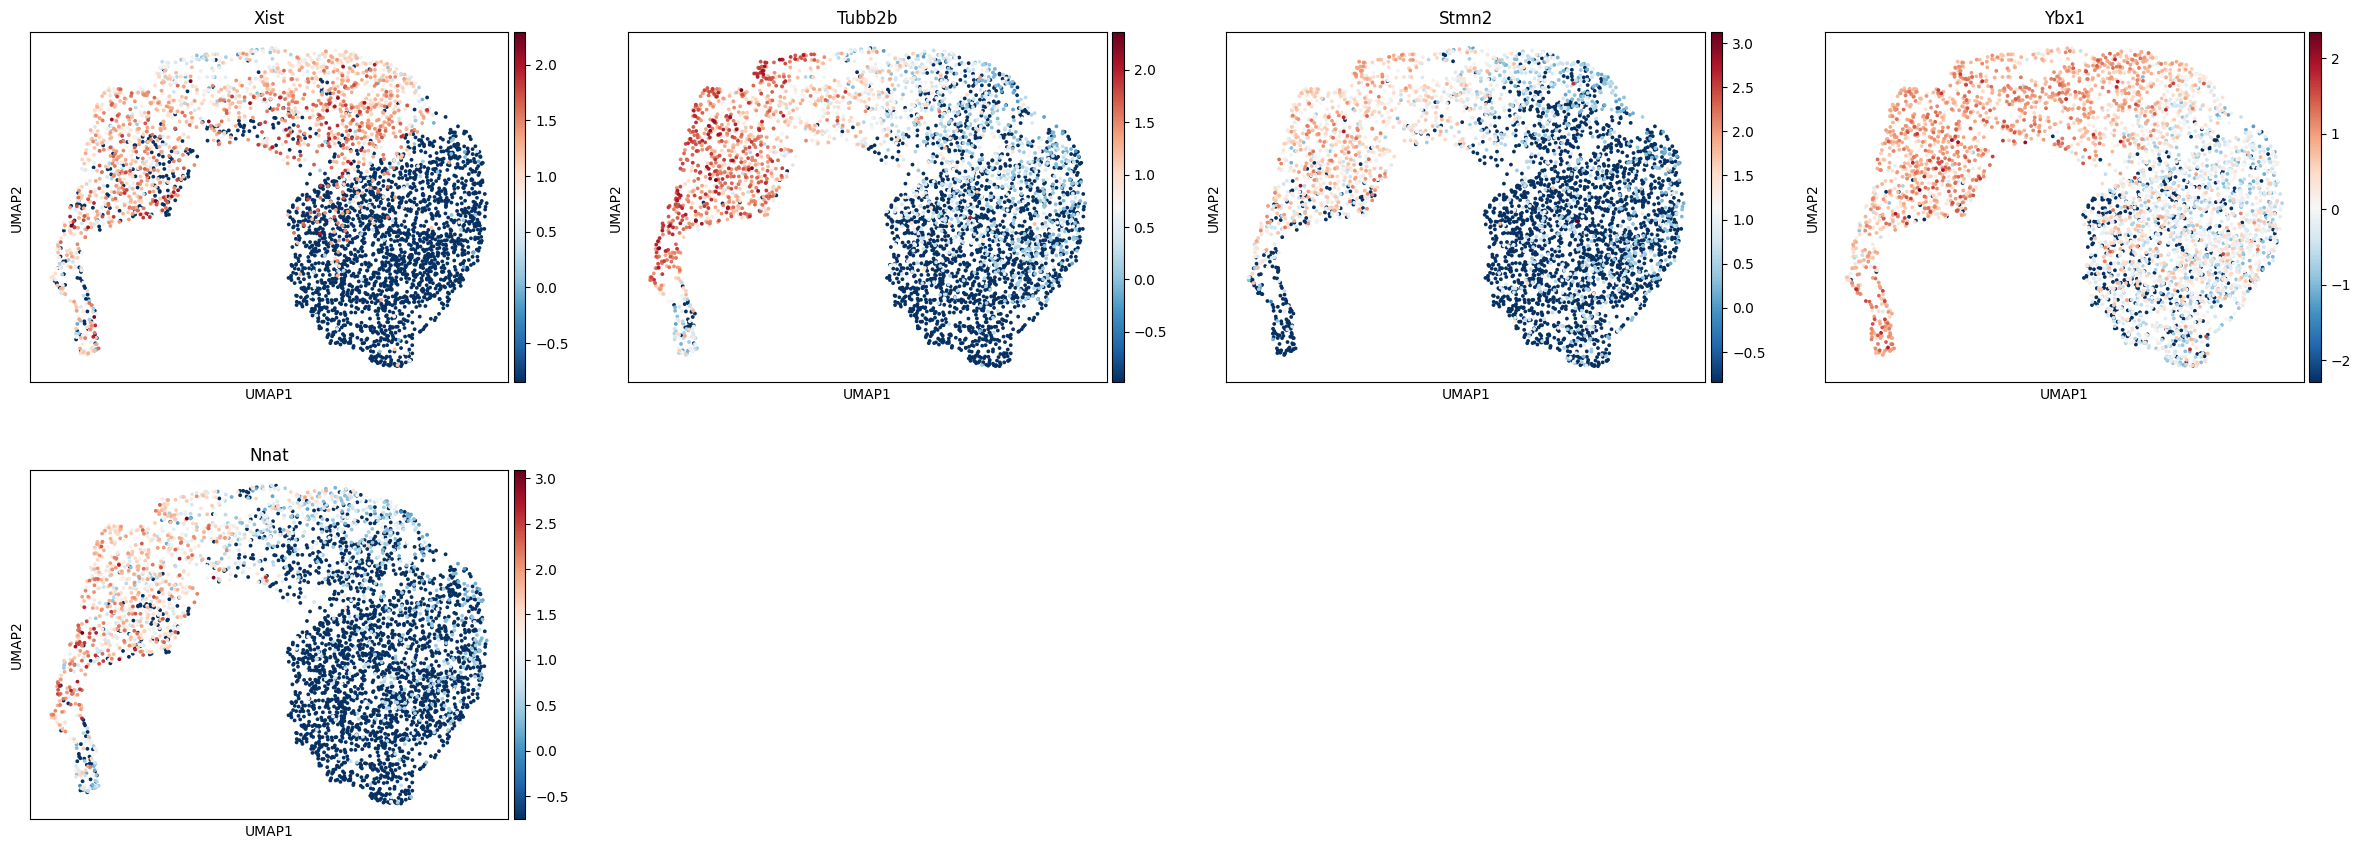

In [20]:
model.visualize_latent(color = maker_genes, method = "UMAP",cmap = "RdBu_r")

# Save and load the model

In [ ]:
# model.save_model(path_to_file="model.checkpoint")

In [ ]:
# load model

# Instantiate model 
# model = VITAE(adata = dd, 
#         hidden_layers = [32, 16],
#         latent_space_dim = 8,
#         model_type = 'Gaussian')

# model.load_model("model.checkpoint",load_labels=True)